In [ ]:
#https://www.kaggle.com/code/itoeiji/deep-reinforcement-learning-on-stock-data
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [ ]:
pip install chainer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chainer: filename=chainer-7.8.1-py3-none-any.whl size=967716 sha256=e5d1d51bb91f12946dd12d1f1cf1d41a12a1ab15b8cf37340575091c0aee24e2
  Stored in directory: /root/.cache/pip/wheels/c4/95/6a/16014db6f761c4e742755b64aac60dbe142da1df6c5919f790
Successfully built chainer


In [ ]:
!pip install yfinance


In [ ]:
pip install plotly

In [ ]:
!pip install --upgrade plotly


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 18.4 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0


In [ ]:
import time
import copy
import numpy as np
import pandas as pd
import chainer
import chainer.functions as F
import chainer.links as L
from plotly import tools
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, iplot_mpl
init_notebook_mode()

In [ ]:
import yfinance as yf
from datetime import datetime, timedelta

# 設定起始日期和結束日期
end_date = datetime.now()
start_date = end_date - timedelta(days=1000)

# 使用yfinance讀取股票數據
symbol = "GOOGL"  # Google的股票代碼
google_stock_data = yf.download(symbol, start=start_date, end=end_date)

# 顯示數據的前幾行
print(google_stock_data.head())


[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-04-01  104.612503  106.787498  104.571503  106.488998  106.488998   
2021-04-05  107.357498  111.449501  107.260498  110.947998  110.947998   
2021-04-06  110.545998  111.400002  110.089500  110.462997  110.462997   
2021-04-07  110.654999  112.224998  110.654999  111.951500  111.951500   
2021-04-08  113.199997  113.589500  112.150497  112.521500  112.521500   

              Volume  
Date                  
2021-04-01  39880000  
2021-04-05  48510000  
2021-04-06  35240000  
2021-04-07  24134000  
2021-04-08  28664000  


In [ ]:
# 將yfinance數據轉換為DataFrame
data = pd.DataFrame(google_stock_data)

# 設定索引為日期
data['Date'] = data.index

# 將日期轉換為datetime類型
data['Date'] = pd.to_datetime(data['Date'])

# 設定索引
data = data.set_index('Date')

# 顯示數據的前幾行
print(data.index.min(), data.index.max())
print(data.head())

2021-04-01 00:00:00 2023-12-26 00:00:00
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-04-01  104.612503  106.787498  104.571503  106.488998  106.488998   
2021-04-05  107.357498  111.449501  107.260498  110.947998  110.947998   
2021-04-06  110.545998  111.400002  110.089500  110.462997  110.462997   
2021-04-07  110.654999  112.224998  110.654999  111.951500  111.951500   
2021-04-08  113.199997  113.589500  112.150497  112.521500  112.521500   

              Volume  
Date                  
2021-04-01  39880000  
2021-04-05  48510000  
2021-04-06  35240000  
2021-04-07  24134000  
2021-04-08  28664000  


In [ ]:
date_split = '2022-08-31'
train = data[:date_split]
test = data[date_split:]
len(train), len(test)

(358, 332)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_train_test(train, test, date_split):
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=('Train Data', 'Test Data'))

    # Add candlestick trace for train data
    fig.add_trace(go.Candlestick(x=train.index,
                open=train['Open'], high=train['High'],
                low=train['Low'], close=train['Close'],
                name='Train'), row=1, col=1)

    # Add candlestick trace for test data
    fig.add_trace(go.Candlestick(x=test.index,
                open=test['Open'], high=test['High'],
                low=test['Low'], close=test['Close'],
                name='Test'), row=2, col=1)

    # Add vertical line for the split date
    fig.add_shape(dict(type="line",
                      x0=date_split, x1=date_split,
                      y0=0, y1=1,
                      xref='x', yref='paper',
                      line=dict(color='black', width=2)))

    # Add annotations for train and test labels
    fig.add_annotation(x=date_split, y=1.0,
                      xref='x', yref='paper',
                      showarrow=False, text='Test Data', xanchor='left')

    fig.add_annotation(x=date_split, y=1.0,
                      xref='x', yref='paper',
                      showarrow=False, text='Train Data', xanchor='right')

    # Update layout
    fig.update_xaxes(title_text='Date', row=2, col=1)
    fig.update_layout(height=600, width=800, showlegend=False)

    # Show the plot
    fig.show()

In [ ]:
def plot_train_test(train, test, date_split):

    data = [
        Candlestick(x=train.index, open=train['Open'], high=train['High'], low=train['Low'], close=train['Close'], name='train'),
        Candlestick(x=test.index, open=test['Open'], high=test['High'], low=test['Low'], close=test['Close'], name='test')
    ]
    layout = {
         'shapes': [
             {'x0': date_split, 'x1': date_split, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper', 'line': {'color': 'rgb(0,0,0)', 'width': 1}}
         ],
        'annotations': [
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'left', 'text': ' test data'},
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'right', 'text': 'train data '}
        ]
    }
    figure = Figure(data=data, layout=layout)
    iplot(figure)

In [ ]:
plot_train_test(train, test, date_split)

In [ ]:
class Environment1:

    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()

    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs

    def step(self, act):
        reward = 0

        # act = 0: stay, 1: buy, 2: sell
        if act == 1:
            self.positions.append(self.data.iloc[self.t, :]['Close'])
        elif act == 2: # sell
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['Close'] - p)
                reward += profits
                self.profits += profits
                self.positions = []

        # set next time
        self.t += 1
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])

        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1

        return [self.position_value] + self.history, reward, self.done # obs, reward, done

In [ ]:
env = Environment1(train)
print(env.reset())
for _ in range(3):
    pact = np.random.randint(3)
    print(env.step(pact))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4.4589996337890625], 0, False)
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4.4589996337890625, -0.4850006103515625], 0, False)
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
# DQN

def train_dqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 50
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 20
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 5

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:

            # select act
            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            # act
            obs, reward, done = env.step(pact)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()

    return Q, total_losses, total_rewards


In [ ]:
Q, total_losses, total_rewards = train_dqn(Environment1(train))

<ipython-input-27-6832e141b56a>:74: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

<ipython-input-27-6832e141b56a>:82: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



5	0.0999999999999992	1785	-18.6	281.60442456072195	17.324196338653564
10	0.0999999999999992	3570	1.6	23.228989265486597	16.999744176864624
15	0.0999999999999992	5355	14.4	15.681766705028712	17.662973642349243
20	0.0999999999999992	7140	15.4	16.656604819744825	16.916563034057617
25	0.0999999999999992	8925	17.0	8.18790392857045	18.989415645599365
30	0.0999999999999992	10710	22.0	13.29373160963878	17.321844577789307
35	0.0999999999999992	12495	25.8	13.379463654011488	17.635647296905518
40	0.0999999999999992	14280	20.0	12.601306878216565	17.190986156463623
45	0.0999999999999992	16065	22.2	11.548456950392573	18.927340030670166
50	0.0999999999999992	17850	29.0	15.397546339500696	17.403944730758667


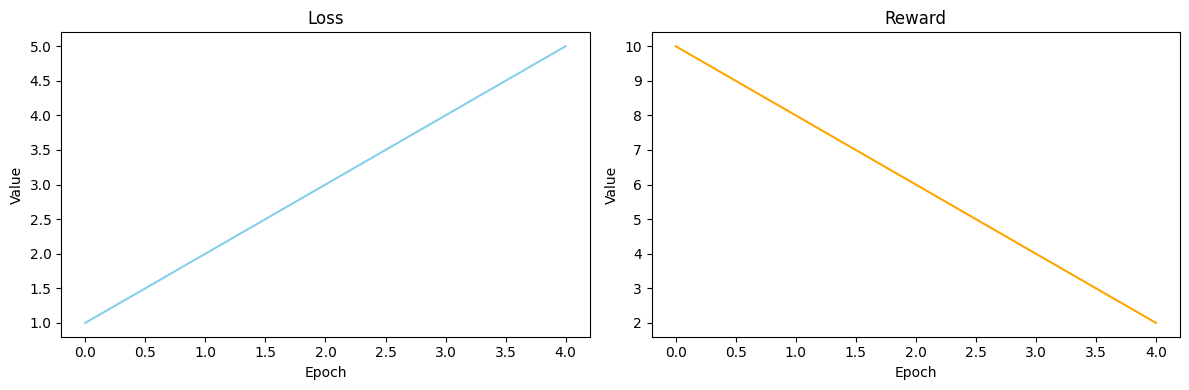

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_reward(total_losses, total_rewards):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(total_losses, color='skyblue', label='loss')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Value')

    axes[1].plot(total_rewards, color='orange', label='reward')
    axes[1].set_title('Reward')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Value')

    plt.tight_layout()
    plt.show()

# Example usage
total_losses = [1, 2, 3, 4, 5]
total_rewards = [10, 8, 6, 4, 2]
plot_loss_reward(total_losses, total_rewards)

In [ ]:
def plot_train_test_by_q(train_env, test_env, Q, algorithm_name):

    # train
    pobs = train_env.reset()
    train_acts = []
    train_rewards = []

    for _ in range(len(train_env.data)-1):

        pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)
        train_acts.append(pact)

        obs, reward, done = train_env.step(pact)
        train_rewards.append(reward)

        pobs = obs

    train_profits = train_env.profits

    # test
    pobs = test_env.reset()
    test_acts = []
    test_rewards = []

    for _ in range(len(test_env.data)-1):

        pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)
        test_acts.append(pact)

        obs, reward, done = test_env.step(pact)
        test_rewards.append(reward)

        pobs = obs

    test_profits = test_env.profits

    # plot
    train_copy = train_env.data.copy()
    test_copy = test_env.data.copy()
    train_copy['act'] = train_acts + [np.nan]
    train_copy['reward'] = train_rewards + [np.nan]
    test_copy['act'] = test_acts + [np.nan]
    test_copy['reward'] = test_rewards + [np.nan]
    train0 = train_copy[train_copy['act'] == 0]
    train1 = train_copy[train_copy['act'] == 1]
    train2 = train_copy[train_copy['act'] == 2]
    test0 = test_copy[test_copy['act'] == 0]
    test1 = test_copy[test_copy['act'] == 1]
    test2 = test_copy[test_copy['act'] == 2]
    act_color0, act_color1, act_color2 = 'gray', 'cyan', 'magenta'

    data = [
        Candlestick(x=train0.index, open=train0['Open'], high=train0['High'], low=train0['Low'], close=train0['Close'], increasing=dict(line=dict(color=act_color0)), decreasing=dict(line=dict(color=act_color0))),
        Candlestick(x=train1.index, open=train1['Open'], high=train1['High'], low=train1['Low'], close=train1['Close'], increasing=dict(line=dict(color=act_color1)), decreasing=dict(line=dict(color=act_color1))),
        Candlestick(x=train2.index, open=train2['Open'], high=train2['High'], low=train2['Low'], close=train2['Close'], increasing=dict(line=dict(color=act_color2)), decreasing=dict(line=dict(color=act_color2))),
        Candlestick(x=test0.index, open=test0['Open'], high=test0['High'], low=test0['Low'], close=test0['Close'], increasing=dict(line=dict(color=act_color0)), decreasing=dict(line=dict(color=act_color0))),
        Candlestick(x=test1.index, open=test1['Open'], high=test1['High'], low=test1['Low'], close=test1['Close'], increasing=dict(line=dict(color=act_color1)), decreasing=dict(line=dict(color=act_color1))),
        Candlestick(x=test2.index, open=test2['Open'], high=test2['High'], low=test2['Low'], close=test2['Close'], increasing=dict(line=dict(color=act_color2)), decreasing=dict(line=dict(color=act_color2)))
    ]
    title = '{}: train s-reward {}, profits {}, test s-reward {}, profits {}'.format(
        algorithm_name,
        int(sum(train_rewards)),
        int(train_profits),
        int(sum(test_rewards)),
        int(test_profits)
    )
    layout = {
        'title': title,
        'showlegend': False,
         'shapes': [
             {'x0': date_split, 'x1': date_split, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper', 'line': {'color': 'rgb(0,0,0)', 'width': 1}}
         ],
        'annotations': [
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'left', 'text': ' test data'},
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'right', 'text': 'train data '}
        ]
    }
    figure = Figure(data=data, layout=layout)
    iplot(figure)


In [ ]:
plot_train_test_by_q(Environment1(train), Environment1(test), Q, 'DQN')